In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from skimage.filters import threshold_multiotsu
import os
import porespy as ps
from tifffile import imwrite
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import torch
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

def clean_img(img_t):
    '''
    2  3^3 median image filter
    3 Otsu binary segmentation
    https://homepages.inf.ed.ac.uk/rbf/HIPR2/median.htm
    https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html
    '''

    thresholds = threshold_multiotsu(img_t,classes=2)
    # from the threshold we separate regions
    img_t = np.digitize(img_t, bins=thresholds)

    return img_t


def img_crop(img,crop_size):
    x_max = img.shape[0]
    y_max = img.shape[1]
    z_max = img.shape[2]

    sec = img[
        crop_size:x_max-crop_size,
        crop_size:y_max-crop_size,
        crop_size:z_max-crop_size
        ]
    return sec


def np_to_tif(img,f_name):
    '''
    convert numpy to tif
    '''

    img_save = (img * 255).astype('uint8')
    # Save the 3D array as a 3D tif
    imwrite(f_name, img_save)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5


from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()

In [2]:
initialize(config_path=f"../config/ex11")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [21]:
img_list = []
for i in range(6):
    img_list.append(
        tif_to_np(
            os.path.join(
                cfg_dataset.PATH.main_vol,
                f'main_{i}.tif'
                )
                  )
        )

img_idx = 1
volume_dimension = 3
img_sample = img_list[img_idx]
img_sample = img_sample[:volume_dimension*64,
                        :volume_dimension*64,
                        :volume_dimension*64]



In [22]:
from lpu3dnet.inference import block_generation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

block_generator = block_generation.Block_generator_compare(
    cfg_dataset,
    cfg_vqgan,
    cfg_transformer,
    epoch_vqgan=25,
    epoch_transformer=100,
    device = device,
    img=img_sample,
    volume_dimension=volume_dimension
    )

block_generator.generate_block()

The shape of comparing image is (192, 192, 192)
number of parameters: 183.94M


0.1691214949996383 0.164886474609375


(-0.5, 191.5, 191.5, -0.5)

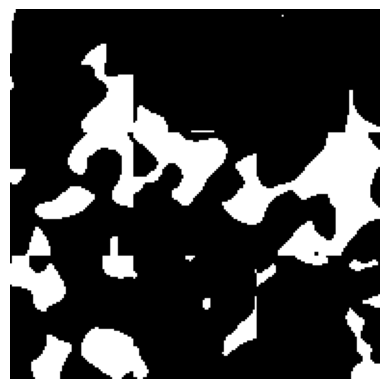

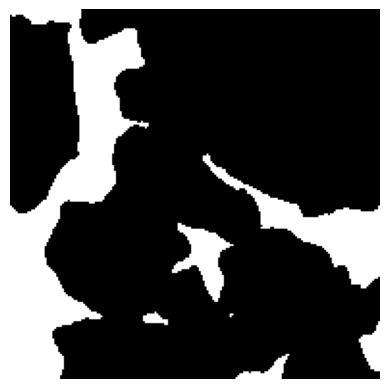

In [23]:
import numpy as np

def get_volume_shape(ds_spatial):
    max_i, max_j, max_k = 0, 0, 0
    for ijk in ds_spatial.keys():
        i, j, k = ijk
        max_i = max(max_i, i)
        max_j = max(max_j, j)
        max_k = max(max_k, k)
    return max_i + 1, max_j + 1, max_k + 1

def assemble_volume(ds_spatial):
    volume_shape = get_volume_shape(ds_spatial)
    volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))
    volume_original = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

    for ijk, data in ds_spatial.items():
        i, j, k = ijk
        image = data['img']
        image_original = data['img_original']
        volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image
        volume_original[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image_original

    return volume,volume_original

volume,volume_original = assemble_volume(block_generator.ds_spatial)

print(img_prc.phi(volume),img_prc.phi(volume_original))

f = plt.figure()
plt.imshow(volume[:,20,:], cmap='gray')
plt.axis('off')
f = plt.figure()
plt.imshow(volume_original[:,0,:], cmap='gray')
plt.axis('off')

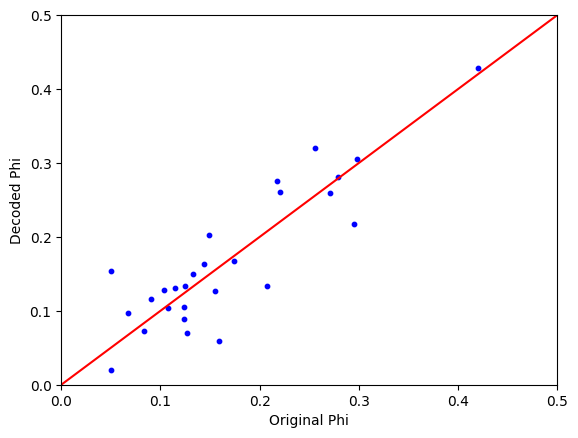

In [24]:
phi_list = []
phi_gen_list = []

for keys in block_generator.ds_spatial.keys():
    phi_list.append(block_generator.ds_spatial[keys]['phi'])
    img = block_generator.ds_spatial[keys]['img']
    phi_gen = img_prc.phi(img)
    phi_gen_list.append(phi_gen)


f = plt.figure()
val_max = 0.5
plt.scatter(phi_list, phi_gen_list,s=10,c='b')
plt.plot([0,val_max],[0,val_max],c='r')
plt.xlim([0,val_max])
plt.ylim([0,val_max])
plt.xlabel('Original Phi')
plt.ylabel('Decoded Phi')
plt.show()

In [3]:
epoch_vqgan = 25
epoch_transformer = 280
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)

vqgan_path = os.path.join(root_path,f'vqgan_epoch_{epoch_vqgan}.pth')
transformer_path = os.path.join(root_path,'transformer',f'transformer_epoch_{epoch_transformer}.pth')

model_vqgan = vqgan.VQGAN(cfg_vqgan)
model_transformer = transformer.Transformer(cfg_transformer)

model_vqgan.load_checkpoint(vqgan_path)
model_transformer.load_checkpoint(transformer_path)

model_vqgan = model_vqgan.to(device)
model_transformer = model_transformer.to(device)

model_transformer.eval()
model_vqgan.eval()

number of parameters: 183.94M


VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

In [4]:
img_list = []
for i in range(6):
    img_list.append(
        tif_to_np(
            os.path.join(
                cfg_dataset.PATH.main_vol,
                f'main_{i}.tif'
                )
                  )
        )

In [8]:
from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()


def init_ds_spatial_info(volume_dimension):
    ds = {}
    for i in range(volume_dimension):
        for j in range(volume_dimension):
            for k in range(volume_dimension):
                # store spatial info
                ds[(i, j, k)] = {}
                ds[(i, j, k)]['phi'] = None
                ds[(i, j, k)]['token'] = None
                ds[(i, j, k)]['z'] = None
                ds[(i, j, k)]['cond'] = None
                ds[(i, j, k)]['img'] = None
    return ds

def patchify_img(img,ds_spatial,volume_dimension):
    # segment images into 64^3 cubic voxels in 2*2*2 spatial grid
    for i in range(volume_dimension):
        for j in range(volume_dimension):
            for k in range(volume_dimension):
                subset_image = img[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64]
                key_idx = (i, j, k)
                ds_spatial[key_idx]['img_original'] = subset_image
                porosity = ps.metrics.porosity(subset_image)
                if porosity < 5e-2:
                    porosity = 0.07
                ds_spatial[key_idx]['phi'] = porosity

    return ds_spatial

def generate_sliding_windows(volume_dimension, window_size=2):
    """
    Generates coordinates for sliding windows in a 3D cubic volume.
    Args:
    - volume_dimension: The size of the cubic volume
    - window_size: The size of the sliding window (default is 2 for a 2x2x2 window)
    Returns:
    - A list of lists, where each inner list contains tuples of (i, j, k) coordinates
      for all points within a window.
    """

    windows = []

    # Traverse the 3D volume
    for i in range(volume_dimension - window_size + 1):
        for j in range(volume_dimension - window_size + 1):
            for k in range(volume_dimension - window_size + 1):
                # Initialize the current window's list of coordinates
                current_window = []
                
                # Populate the current window with coordinates
                for di in range(window_size):
                    for dj in range(window_size):
                        for dk in range(window_size):
                            current_window.append((i+di, j+dj, k+dk))
                
                # Add the current window's coordinates to the main list
                windows.append(current_window)

    return windows


def expand_cond_single(cond_base,features_num=27):
     
     cond_flatten = cond_base.unsqueeze(0).expand(features_num, -1)
     return cond_flatten.unsqueeze(0).float()

def gen_img_from_z(z):
    with torch.no_grad():
        img = model_vqgan.decode(z)
        img = img_prc.clean_img(img)[0]
    return img


def add_noise_to_cond(cond,device):
    b,seq_len,_ = cond.shape
    noise = torch.randn(b, seq_len, 1).to(device)
    cond = torch.cat([cond, noise], dim=-1)
    return cond.float()


sample_idx = 0
img_sample = img_list[sample_idx]
volume_dimension = 3
sub_img_size = 2

windows_idx = generate_sliding_windows(volume_dimension)
ds_spatial = init_ds_spatial_info(volume_dimension)
ds_spatial = patchify_img(img_sample,ds_spatial,volume_dimension)

In [9]:
sos_token = 3000
top_k = 2
features_num = 64

phi = ds_spatial[(0,0,0)]['phi']
cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
cond_vec = expand_cond_single(cond_vec,features_num=features_num)
# cond_vec = add_noise_to_cond(cond_vec,device)

sos_tokens = torch.ones(1, features_num) * sos_token
sos_tokens = sos_tokens.long().to(device)


img_origin = ds_spatial[(0,0,0)]['img_original']
img_origin = np.expand_dims(img_origin, axis=0)
img_origin = np.expand_dims(img_origin, axis=0)
img_origin = torch.from_numpy(img_origin).to(device).float()
# token_nxt = model_vqgan.gen_img_tokens(img_origin)

token_nxt = model_transformer.model.sample(sos_tokens, cond_vec,top_k=top_k,features_num=features_num)
z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=features_num)

ds_spatial[(0,0,0)]['cond'] = cond_vec
ds_spatial[(0,0,0)]['z'] = z_current
ds_spatial[(0,0,0)]['token'] = token_nxt
ds_spatial[(0,0,0)]['img'] = gen_img_from_z(z_current)


for slide_window_idx in windows_idx:
    flat_idx = 0
    # initialize aggregated vector in each window
    cond_window = []
    token_list = [sos_tokens]
    # create normalized ijk condition vector
    for i in range(sub_img_size):
        for j in range(sub_img_size):
            for k in range(sub_img_size):
                # get absolute
                abs_ijk = slide_window_idx[flat_idx]
                

                if ds_spatial[abs_ijk]['token'] is not None:
                    cond_vec = ds_spatial[abs_ijk]['cond'].clone()
                    token_current = ds_spatial[abs_ijk]['token'].clone()
                    cond_window.append(cond_vec)
                    token_list.append(token_current)
                    flat_idx += 1
                    continue # no need for inference
                
                phi = ds_spatial[abs_ijk]['phi']
                # generate conditional informatino
                cond_vec = torch.tensor([phi, i, j, k]).to(device)
                cond_vec = expand_cond_single(cond_vec,features_num=features_num)
                # cond_vec = add_noise_to_cond(cond_vec,device)
                cond_window.append(cond_vec)
                cond_input = torch.cat(cond_window, dim=1)

                # aggregate previous tokens
                token_input = torch.cat(token_list, dim=1)
                token_nxt = model_transformer.model.sample(token_input, cond_input,top_k=top_k,features_num=features_num)
                token_list.append(token_nxt)

                # update spatial ds
                ds_spatial[abs_ijk]['token'] = token_nxt
                ds_spatial[abs_ijk]['cond'] = cond_vec
                z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=features_num)
                ds_spatial[abs_ijk]['z'] = z_current
                ds_spatial[abs_ijk]['img'] = gen_img_from_z(z_current)
                
                flat_idx += 1

0.9847755432128906 0.15784835815429688


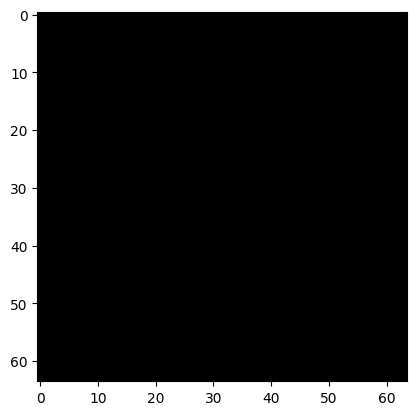

In [10]:
# visulize (0,0,0)
img = ds_spatial[(0,0,0)]['img']
f = plt.figure()
plt.imshow(img[:,0,:],cmap='gray')


print(img_prc.phi(img),ds_spatial[(0,0,0)]['phi'])

(-0.5, 191.5, 191.5, -0.5)

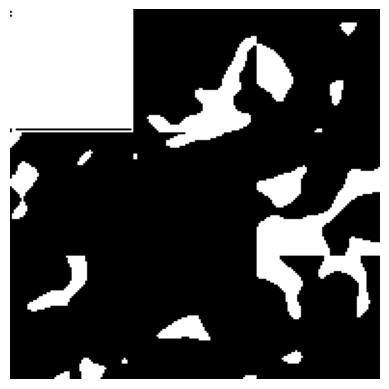

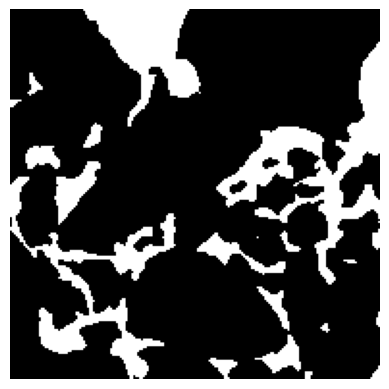

In [11]:
import numpy as np

def get_volume_shape(ds_spatial):
    max_i, max_j, max_k = 0, 0, 0
    for ijk in ds_spatial.keys():
        i, j, k = ijk
        max_i = max(max_i, i)
        max_j = max(max_j, j)
        max_k = max(max_k, k)
    return max_i + 1, max_j + 1, max_k + 1

def assemble_volume(ds_spatial):
    volume_shape = get_volume_shape(ds_spatial)
    volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))
    volume_original = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

    for ijk, data in ds_spatial.items():
        i, j, k = ijk
        image = data['img']
        image_original = data['img_original']
        volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image
        volume_original[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image_original

    return volume,volume_original

volume,volume_original = assemble_volume(ds_spatial)

f = plt.figure()
plt.imshow(volume[0,:,:], cmap='gray')
plt.axis('off')
f = plt.figure()
plt.imshow(volume_original[0,:,:], cmap='gray')
plt.axis('off')

/tmp/ipykernel_1447189/2306626530.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  filled = np.ones((img.shape[0], img.shape[1], img.shape[2]), dtype=np.bool)


KeyboardInterrupt: 

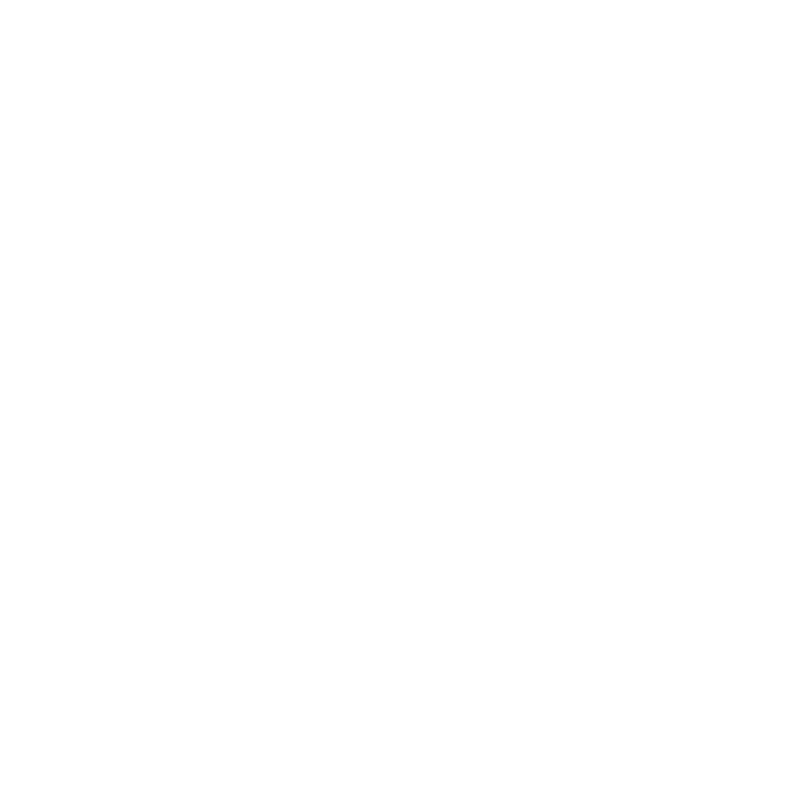

In [35]:
def plot_3D(img): 
    # Generating a 3D sine wave
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    # Set black and white colors based on boolean_data
    # colors = np.empty(img.shape + (4,), dtype=np.float32)
    colors = np.empty(img.shape, dtype=object)

    colors[img] = 'white'  # White for True values
    colors[~img] = 'black'  # Black for False values

    plt.axis('off')
    filled = np.ones((img.shape[0], img.shape[1], img.shape[2]), dtype=np.bool)

    # Display the boolean_data using voxels
    ax.voxels(filled, facecolors=colors,edgecolors=colors)

    # Show the plot
    plt.show()

    # Plot the 3D image
plot_3D(volume[:128,:128,:128]>0)

In [9]:
np.save('data_ref/1_pred.npy', volume)

#### Observation
* all sections look similar - not enough variations

In [9]:
phi_list = []
phi_gen_list = []

for keys in ds_spatial.keys():
    phi_list.append(ds_spatial[keys]['phi'])
    img = ds_spatial[keys]['img']
    phi_gen = img_prc.phi(img)
    phi_gen_list.append(phi_gen)

In [10]:
def mean_squared_error(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("The lists must have the same length.")
    
    squared_errors = [(x - y) ** 2 for x, y in zip(list1, list2)]
    mse = sum(squared_errors) / len(list1)
    return mse

err = mean_squared_error(phi_list, phi_gen_list)
print(err)

0.0021331879127925884


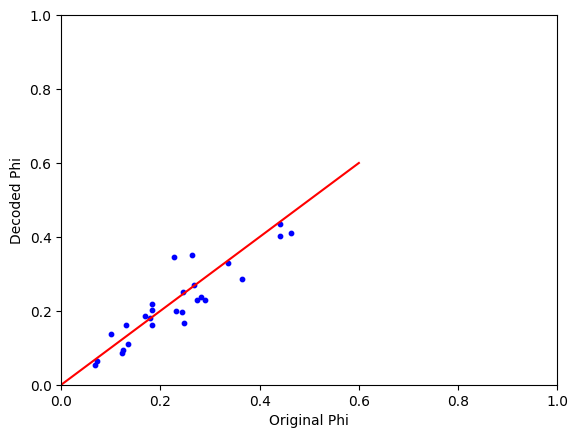

In [11]:
f = plt.figure()
plt.scatter(phi_list, phi_gen_list,s=10,c='b')
plt.plot([0,0.6],[0,0.6],c='r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Original Phi')
plt.ylabel('Decoded Phi')
plt.show()